## Алгоритм компенсации

Обозначим список ключевых изменяющихся параметров (напрямую влияющие на фактический вылив):

1. Ограничения насосов (мин/макс скорость, и их параметры ускорения/остановки)
2. Норма внесения
3. Максимально допустимая скорость дрона

Обозначим порядок в котором будем менять параметры:
1. Скорость дрона
2. Норма внесения


Возьмём в качестве критического значения вызывающего пересчёт с компенсацией:

`max_available_error_litters = 1`

Также не маловажно определить политику важности направления ошибки (есть ли разница, и что важнее - перелить или недолить):
на текущий момент будем считать это равным


### Итак, разберём следующие варианты:

1. Запрещается переливать (допускается недолив):
    - Насосы будут отключаться в случаях когда требуется работать на меньшей скорости чем они могут.

2. Запрет на недолив (допускается перелив):
    - Насосы будут переливать (работать на своем минимуме, даже когда требуется меньшая скорость)
    - Максимальная скорость дрона будет снижена


In [1]:

import matplotlib.pyplot as plt
import numpy as np

In [70]:
from use_cases import PumpFacade, PumpingPolicy
from parse_log import Plan
from pathlib import Path

req_norma = 60  # Л/Га
drone_v_max = 2.0  # максимально допустимая скорость дрона (м/с)

pump_min_speed = 2  # л/мин
pump_max_speed = 13  # л/мин

tank_volume = 40  # л

log_file_path = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(log_file_path)


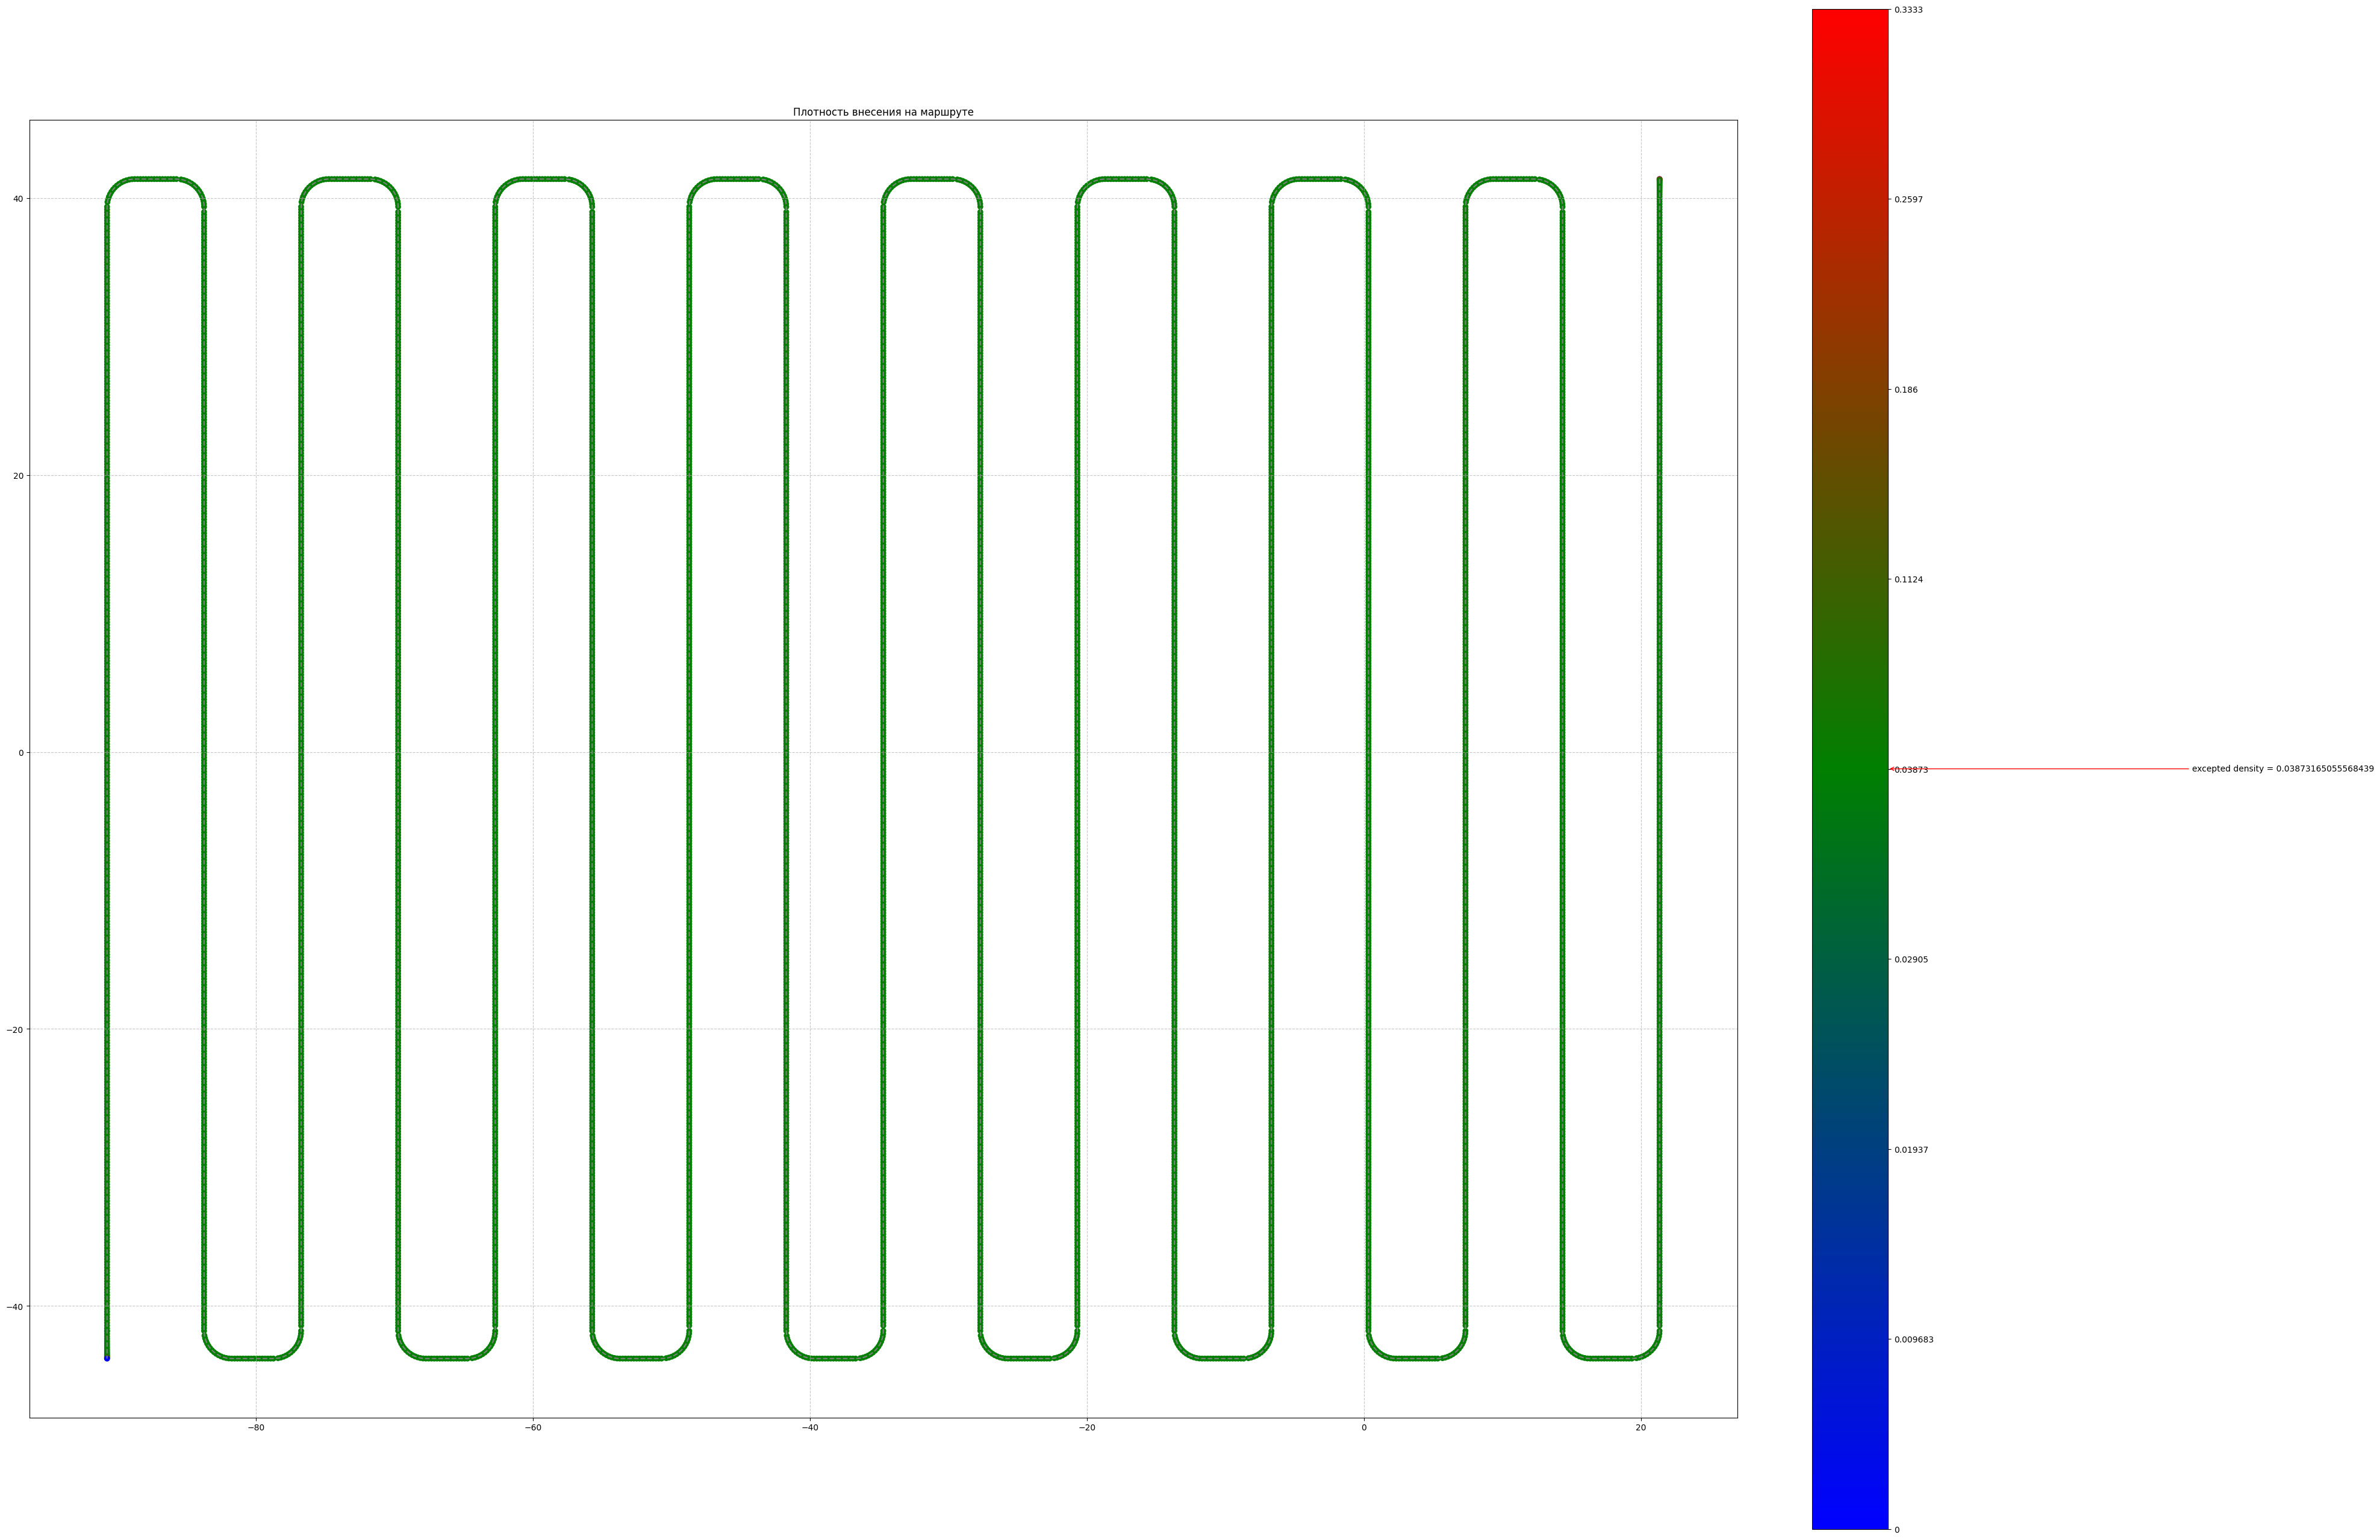

In [71]:
pf = PumpFacade.from_simple_params(plan=plan,
                                   norma=req_norma,
                                   max_drone_speed=drone_v_max,
                                   pump_min_speed=pump_min_speed,
                                   pump_max_speed=pump_max_speed,
                                   tank_volume=tank_volume,
                                   pumping_policy=PumpingPolicy.NoUnderfillPolicy)

pf.plot()

In [72]:
pf.total_dispensed_by_pump_plan, pf.volume_total

(59.39088706706106, 59.3654625015225)

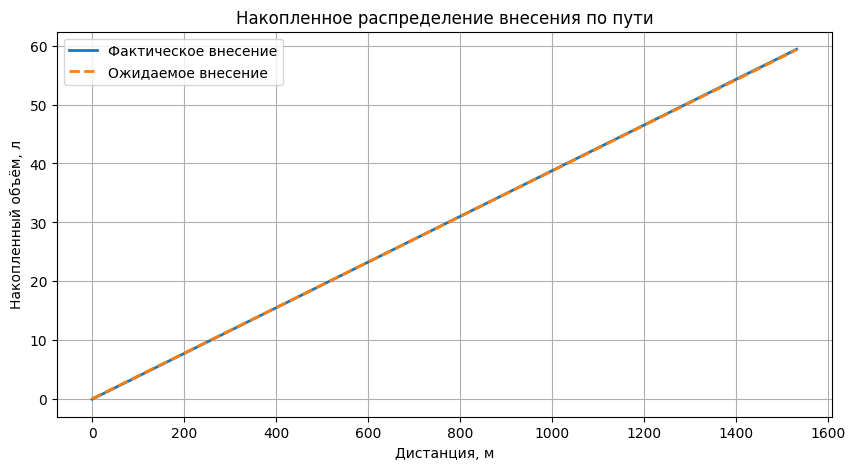

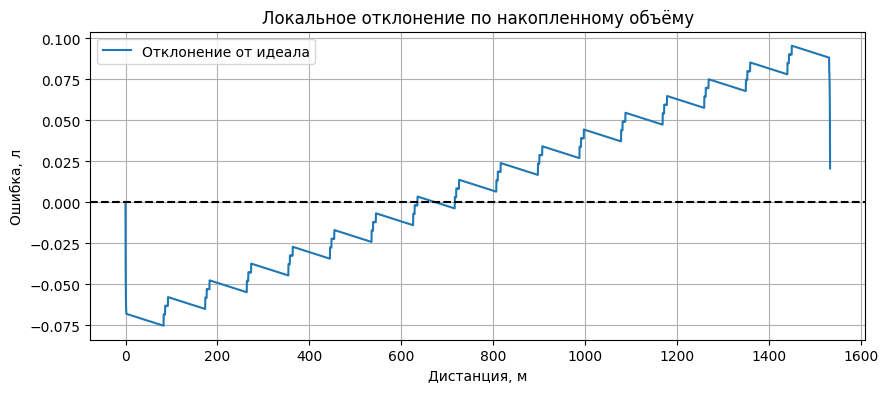

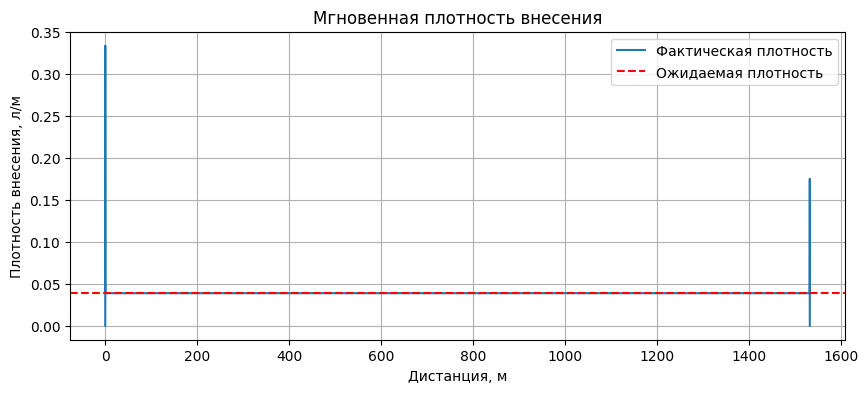

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# фактический накопленный объём по дистанции
# Δs между точками (в метрах)
ds = np.diff([0] + pf.s_list)  # список шагов по пути
fact_cumulative = np.cumsum(pf.instant_introduction_density * ds)

# ожидаемая линейная кривая (идеальное равномерное внесение)
expected_cumulative = np.linspace(0, pf.volume_total, len(pf.s_list))

# === Визуализация ===
plt.figure(figsize=(10, 5))
plt.plot(pf.s_list, fact_cumulative, label="Фактическое внесение", linewidth=2)
plt.plot(pf.s_list, expected_cumulative, label="Ожидаемое внесение", linestyle="--", linewidth=2)
plt.xlabel("Дистанция, м")
plt.ylabel("Накопленный объём, л")
plt.title("Накопленное распределение внесения по пути")
plt.legend()
plt.grid(True)
plt.show()

error = fact_cumulative - expected_cumulative
plt.figure(figsize=(10, 4))
plt.plot(pf.s_list, error, label="Отклонение от идеала")
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Дистанция, м")
plt.ylabel("Ошибка, л")
plt.title("Локальное отклонение по накопленному объёму")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(pf.s_list, pf.instant_introduction_density, label="Фактическая плотность")
plt.axhline(pf.density, color="red", linestyle="--", label="Ожидаемая плотность")
plt.xlabel("Дистанция, м")
plt.ylabel("Плотность внесения, л/м")
plt.title("Мгновенная плотность внесения")
plt.legend()
plt.grid(True)
plt.show()


In [76]:
abs_error = abs(pf.total_dispensed_by_pump_plan - pf.volume_total)
print(f"{abs_error=}")

abs_error=0.02542456553855743


In [77]:
fact_density = pf.total_dispensed_by_pump_plan / pf.profile.total_distance
abs_density_error = abs(fact_density - pf.density)
rel_density_error = abs_density_error / pf.density

print(f"{abs_density_error=} {rel_density_error=}")

abs_density_error=1.6587681565594092e-05 rel_density_error=0.0004282720030675178


In [78]:
pf.volume_total / pf.density

1532.7377390274896

In [79]:
pf.instant_introduction_density

array([0.        , 0.33333333, 0.16666667, ..., 0.11468976, 0.17485041,
       0.        ], shape=(7647,))

In [80]:
from pprint import pprint
from metrics import TotalVolumeError, UniformityError, StopOverflowError, ErrorEvaluator

metrics = [
    TotalVolumeError(),
    UniformityError(),
    StopOverflowError(),
]

weights = {
    "rel_total_volume_error": 0.5,
    "mse_density": 0.3,
    "stop_overflow_ratio": 0.2,
}

# допустим, мы ожидаем что:
normalization = {
    "rel_total_volume_error": (0, 0.1),  # - относительная ошибка < 0.1 нормально
    "mse_density": (0, 0.01),  # - mse_density < 0.01 нормально
    "stop_overflow_ratio": (0, 0.05),  # - stop_overflow_ratio < 0.05 нормально
}

evaluator = ErrorEvaluator(metrics, weights=weights, normalization=normalization)

results = evaluator.evaluate(
    v_motion=pf.speed_list,
    v_pump=pf.pump_plan.q,
    dt=pf.dt,
    volume_total=pf.volume_total,
    target_density=pf.density,
)

pprint(results)


{'abs_total_volume_error': np.float64(0.2625246057193422),
 'fact_total_volume': np.float64(59.10293789580316),
 'integral_score': np.float64(0.022657421091197193),
 'mae_density': np.float64(0.00011963991057941875),
 'mse_density': np.float64(1.8217805553820577e-05),
 'rel_total_volume_error': np.float64(0.0044221773849165156),
 'stop_overflow_ratio': np.float64(0.0),
 'stop_overflow_volume': np.float64(0.0)}


In [81]:
float(results['integral_score'])

0.022657421091197193

In [83]:
def try_compensate_by_decrease_drone_speed(plan: Plan,
                                           req_norma: float,  # Требуемая норма внесения Л/Га
                                           drone_v_min=2,  # минимально допустимая скорость дрона (м/с)
                                           drone_v_max=10.0,  # максимально допустимая скорость дрона (м/с)

                                           pump_min_speed=2,  # л/мин
                                           pump_max_speed=13,  # л/мин

                                           tank_volume=40,  # л
                                           pumping_policy: PumpingPolicy = PumpingPolicy.NoUnderfillPolicy,
                                           mse_eps=1e-4,  # допустимая ошибка плотности внесения
                                           _num=20,
                                           # число разбиений интервала для выбора наилучшего ограничения максимальной скорости дрона
                                           ):
    speed_values = np.linspace(drone_v_min, drone_v_max, num=_num)

    results = {}
    for v in speed_values:
        pf = PumpFacade.from_simple_params(plan=plan,
                                           norma=req_norma,
                                           max_drone_speed=v,
                                           pump_min_speed=pump_min_speed,
                                           pump_max_speed=pump_max_speed,
                                           tank_volume=tank_volume,
                                           pumping_policy=pumping_policy)

        results[v] = pf.mse_density

    min_mse = min(results.values())
    if min_mse > mse_eps:
        raise ValueError("Нерешаемая задача")

    # выбираем скорость, при которой ошибка минимальна
    best_v = min(results, key=results.get)

    return best_v, min_mse


In [84]:
try_compensate_by_decrease_drone_speed(
    plan=plan,
    req_norma=10,
)

(np.float64(3.263157894736842), np.float64(7.359064821465127e-05))

In [14]:
r = {}
for n in np.linspace(0.5, 250, 100):
    pf = PumpFacade.from_simple_params(plan=plan,
                                       norma=n,
                                       max_drone_speed=2,
                                       pump_min_speed=pump_min_speed,
                                       pump_max_speed=pump_max_speed,
                                       tank_volume=tank_volume,
                                       pumping_policy=PumpingPolicy.NoUnderfillPolicy)
    r[n] = {
        'mse_density': float(pf.mse_density),
        'diff': pf.total_dispensed_by_pump_plan - pf.volume_total
    }

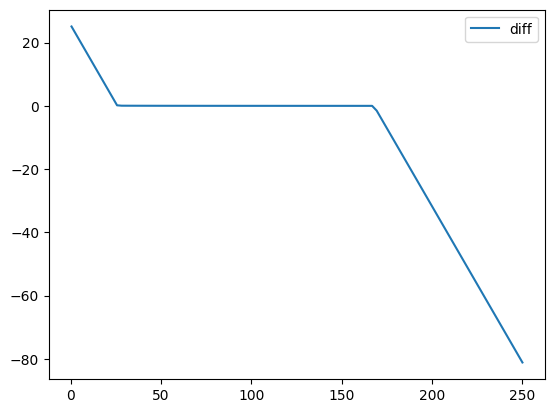

In [85]:
mse = np.array([v['mse_density'] for v in r.values()])
diff = np.array([v['diff'] for v in r.values()])

plt.plot(r.keys(), diff, label='diff')
plt.legend()

In [86]:
a = np.where(abs(diff) < 0.5, 1, 0)

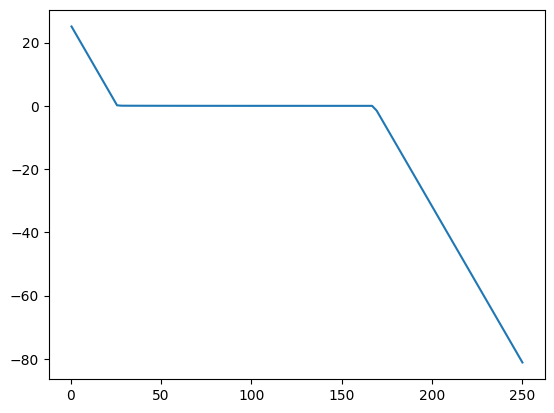

In [91]:
x = r.keys()
y = diff
plt.plot(x, y)

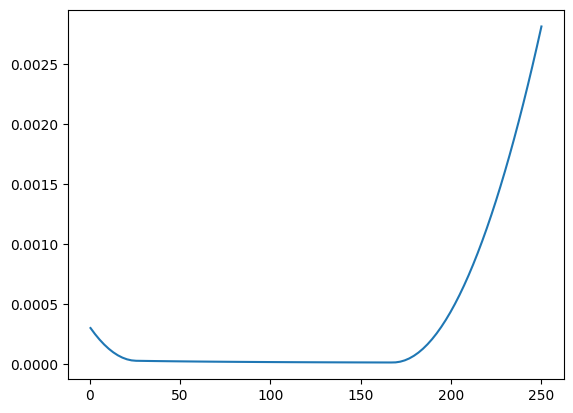

In [88]:
plt.plot(r.keys(), mse, label='mse')

In [19]:
mse = ((pf.instant_introduction_density - pf.density) ** 2).mean()

In [20]:
pf.profile.total_distance

1532.7377390274896

In [21]:
pf.profile.total_duration

768.3688695137448

In [22]:
pf.density

np.float64(0.1613818773153516)

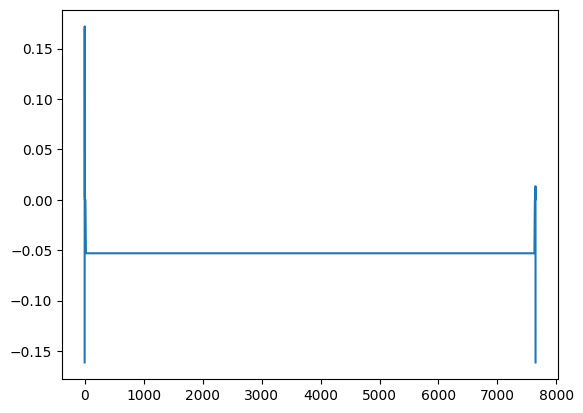

In [23]:
plt.plot(pf.diff_density)

In [24]:
diff = pf.instant_introduction_density

# ещё

In [25]:
# pf = PumpFacade.from_simple_params(plan=plan,
#                                    norma=req_norma,
#                                    max_drone_speed=drone_v_max,
#                                    pump_min_speed=pump_min_speed,
#                                    pump_max_speed=pump_max_speed,
#                                    tank_volume=tank_volume,
#                                    pumping_policy=PumpingPolicy.NoOverflowPolicy)
#
# pf.plot()
# d = pf.density

In [26]:
# policy = PolicyFactory.with_tolerance(over_tol=0.5,  # Допускаем переливать 0,5 л
#                                       under_tol=0.5,  # Допускаем не доливать 0,5 л
#                                       w_over=2,  # Переливание в 2 раза хуже
#                                       violation=ViolationMode.IGNORE  # Кидаем исключения при нарушениях
#                                       )
#
# target = 0
# x = np.linspace(-10, 10, 21) / 10
# y = [policy.cost(target, i) for i in x]
# plt.plot(x, y)